In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn



/uscms_data/d3/ekoenig/miniforge3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def _subset(f):
  return f.replace('ntuple.root','output/ntuple_1*')
tree = ObjIter([ Tree( _subset(f) ) for f in fc.eightb.training.signal_list ])

In [3]:
jet_features = ["jet_ptRegressed",
                "jet_mRegressed",
                "jet_eta",
                "jet_phi",
                "jet_btag"]

In [4]:
def yaml_format(*args):
    args = ', '.join([ str(a) for a in args])
    print(f'- [{args}]')

In [5]:
def make_vars(t):
  X_E = np.sqrt( t.X_m**2 + t.X_pt**2 )
  rel_jet_pt = t.jet_ptRegressed/X_E
  rel_jet_m = t.jet_mRegressed/X_E
  t.extend(
    X_E=X_E,
    rel_jet_m=rel_jet_m,
    rel_jet_pt=rel_jet_pt
  )

tree.apply(make_vars)

[None, None, None, None, None, None, None, None]

In [6]:
def get_avg(var, scale=None):
  if scale is None: return ak.mean(var)
  weight = flatten(scale)
  if weight.shape != var:
      weight = flatten(ak.ones_like(var)*scale)
  return ak.sum(var*scale)/ak.sum(scale)

In [7]:
jet_features = ["rel_jet_pt",
                "rel_jet_m",
                "jet_eta",
                "jet_phi",
                "jet_btag"]

global_features = ["X_E"]

In [8]:
[ yaml_format(f, ak.mean(tree[f].cat),1/ak.std(tree[f].cat)) for f in jet_features ]

- [rel_jet_pt, 0.0957038079260603, 14.775642869146767]
- [rel_jet_m, 0.012911317160638447, 88.48914050056138]
- [jet_eta, -0.0029959369199619385, 0.9473924709872061]
- [jet_phi, -0.0006603617548230183, 0.5506375993393454]
- [jet_btag, 0.5526614323368326, 2.3579368038776116]


[None, None, None, None, None]

In [9]:
[ yaml_format(f, ak.mean(tree[f].cat),1/ak.std(tree[f].cat)) for f in global_features ]

- [X_E, 1092.5043827756576, 0.0023638493228948566]


[None]

In [41]:
mxlist = [700,800,900,1000,1200]
mylist = [300,350,400,450,500]

100%|██████████| 2/2 [00:00<00:00,  4.38it/s]


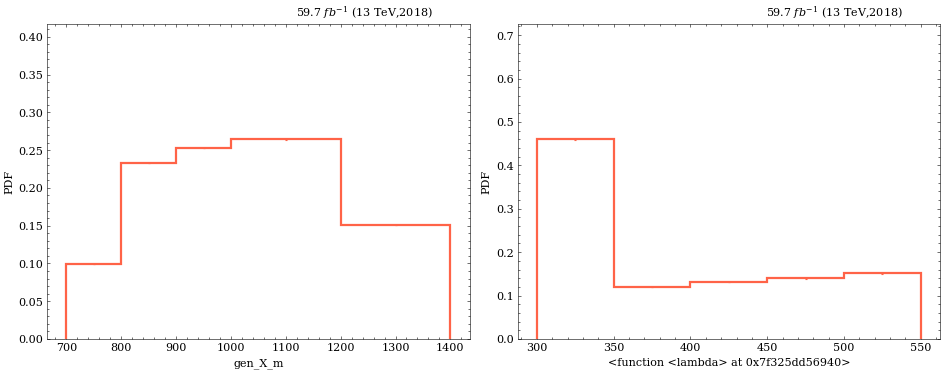

In [35]:
study.quick_region(
  tree,
  varlist=['gen_X_m', lambda t: (t.gen_Y1_m+t.gen_Y2_m)/2],
  binlist=[np.array((700,800,900,1000,1200,1400)),np.array((300,350,400,450,500,550))],
  efficiency=True,
)

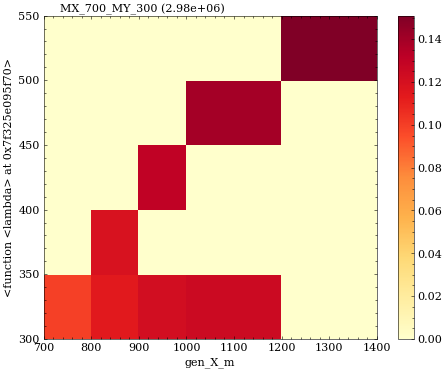

In [36]:
study.quick2d_region(
  tree,
  varlist=['gen_X_m', lambda t: (t.gen_Y1_m+t.gen_Y2_m)/2],
  binlist=[np.array((700,800,900,1000,1200,1400)),np.array((300,350,400,450,500,550))],
  efficiency=True,
)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

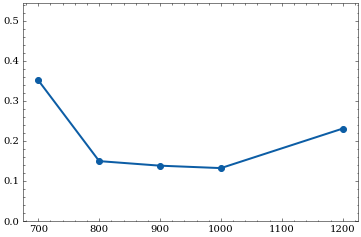

In [86]:
h_mx = Histo(tree.gen_X_m.cat, bins=np.array((700,800,900,1000,1200,1400)))

rescale_mx = Graph(np.array(mxlist), h_mx.histo.max()/h_mx.histo)
rescale_mx = rescale_mx/rescale_mx.y_array.sum()
plot_graph(rescale_mx)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

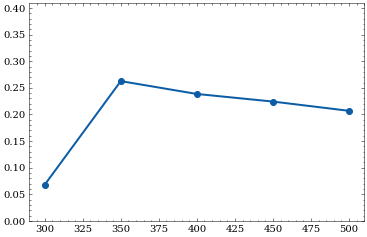

In [87]:
h_my = Histo(tree.gen_Y1_m.cat, bins=np.array((300,350,400,450,500,550)))

rescale_my = Graph(np.array(mylist), h_my.histo.max()/h_my.histo)
rescale_my = rescale_my/rescale_my.y_array.sum()
plot_graph(rescale_my)

In [88]:
scale_mx = tree.gen_X_m.apply(ak.max).apply(rescale_mx.evaluate)
scale_my = tree.gen_Y1_m.apply(ak.max).apply(rescale_my.evaluate)

In [93]:
scale_mxy = scale_mx.npy * scale_my.npy
scale_mxy = scale_mxy/scale_mxy.sum()

100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


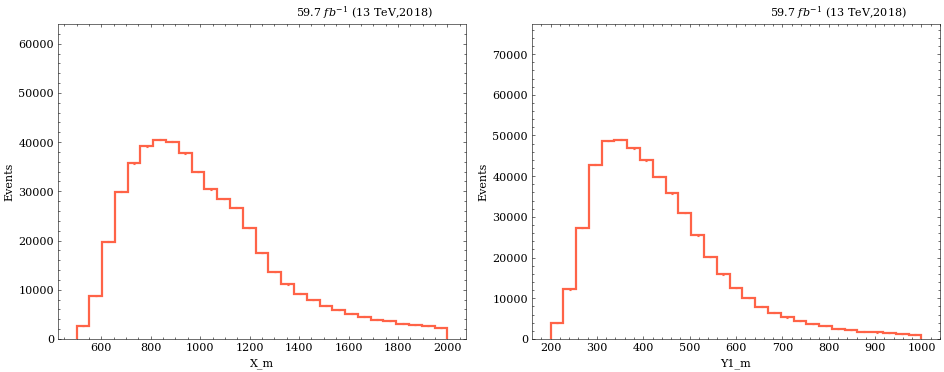

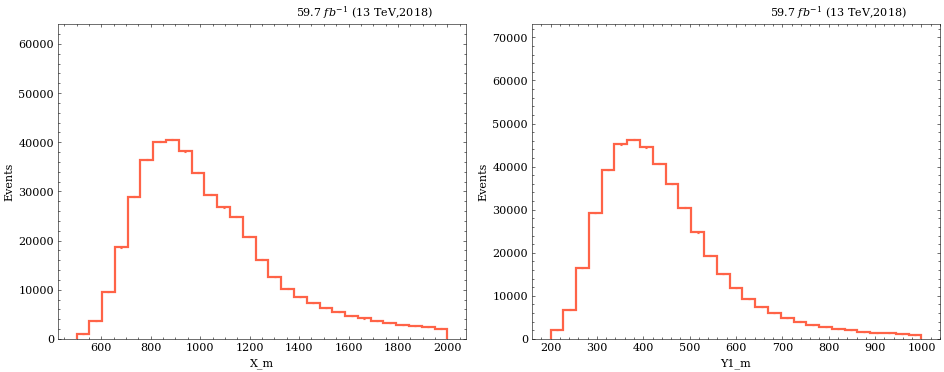

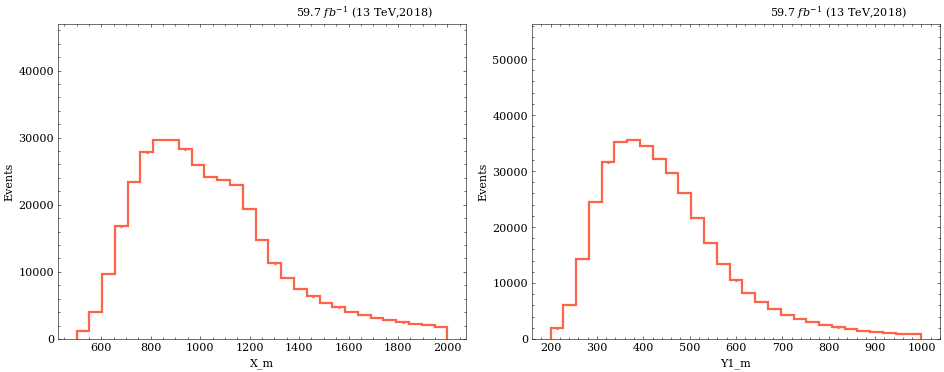

In [94]:
study.quick_region(
  tree,
  scale=scale_mx,
  varlist=['X_m','Y1_m']
)

study.quick_region(
  tree,
  scale=scale_my,
  varlist=['X_m','Y1_m']
)

study.quick_region(
  tree,
  scale=scale_mxy,
  varlist=['X_m','Y1_m']
)

In [96]:
scale_mxy

array([0.11826801, 0.05029502, 0.19442919, 0.04645624, 0.16308451,
       0.04442185, 0.14659848, 0.23644671])